In [1]:
import numpy as np
import mat73
import matplotlib.pyplot as plt

# Data loading and preprocessing

disclaimer: I've not worked with spiking data so this could all be wrong, and I'm not referencing anything for guidance just my silly little brain

In [2]:
data_file = "/home/yoel/Downloads/CRE181_150401_data.mat"

In [3]:
data_dict = mat73.loadmat(data_file)

In [4]:
data_dict["data"].keys()

dict_keys(['pos_ts', 'pos_x', 'pos_y', 'session', 'spikes_ts', 'tetrodes'])

In [5]:
session_index = 0

time = data_dict["data"]["pos_ts"][session_index]

pos_x = data_dict["data"]["pos_x"][session_index]

pos_y = data_dict["data"]["pos_y"][session_index]

spikes = data_dict["data"]["spikes_ts"][session_index] # spike times detected in all 91 tetrodes

tetrodes = data_dict["data"]["tetrodes"][session_index] # session array with 91 tetrode labels per array

bin_width = 5 # 5 sec bin width for no good reason

n_bins = np.floor((spikes[0][-1] - spikes[0][0]) / bin_width).astype(int)

In [6]:
def smoothed_vals(vals, bin_edgs):
    wins = np.array([(bin_edgs[j], bin_edgs[j+1]) for j in range(len(bin_edgs)-1)])
    
    inds = [np.logical_and(wins[j, 0] < vals, vals < wins[j, 1]) 
                for j in range(len(bin_edgs)-1)]
    
    avg_vals = np.array([vals[i].mean() for i in inds])
    
    return avg_vals

In [7]:
time[100]

2.02

In [8]:
def avg_pos(pos_x, pos_y, bin_edgs, time):
    time_wins = np.array([(bin_edgs[j], bin_edgs[j+1]) for j in range(len(bin_edgs)-1)])
    
    time_inds= [np.logical_and(time_wins[j, 0] < time, time < time_wins[j, 1]) 
                for j in range(len(bin_edgs)-1)]

    seconds = np.array([(time[ind][-1] - time[ind][0])  for ind in time_inds])
    
    avg_pos_x = np.array([pos_x[ind].mean() for ind in time_inds])

    avg_pos_y = np.array([pos_y[ind].mean() for ind in time_inds])
                         
    return avg_pos_x, avg_pos_y, seconds

In [9]:
def get_spikes(spikes, pos_x, pos_y, n_bins, time):
    spike_counts, bin_edges = [], []
    avg_x_tm, avg_y_tm = [], []
    rates = []
    
    for spk in spikes:
        spk_cnt, spk_tm = np.histogram(spk, n_bins)
        
        spike_counts.append(spk_cnt)
        
        x, y, seconds = avg_pos(pos_x, pos_y, spk_tm, time)
        
        bin_edges.append(spk_tm)
        
        avg_x_tm.append(x)
        
        avg_y_tm.append(y)
        
        rates.append(spk_cnt / seconds)
    
    spike_counts = np.vstack(spike_counts).T # time points by tetrodes
    
    avg_x = np.vstack(avg_x_tm).T
    
    avg_y = np.vstack(avg_y_tm).T
    
    rates = np.vstack(rates).T
    
    return spike_counts, avg_x, avg_y, rates

In [10]:
S, x, y, rates = get_spikes(spikes, pos_x, pos_y, n_bins, time)
Y = np.hstack([x.mean(1)[:, None], y.mean(1)[:, None]])

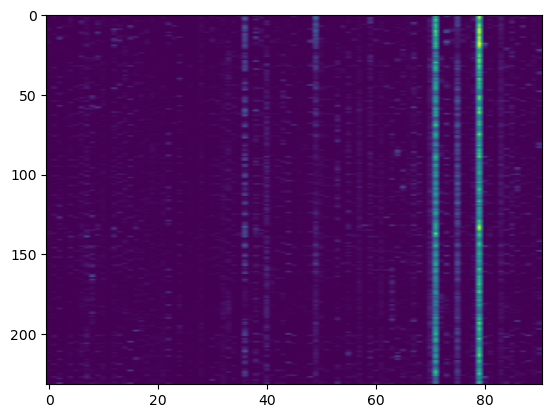

In [11]:
plt.imshow(rates, aspect="auto")

(0.0, 10.0)

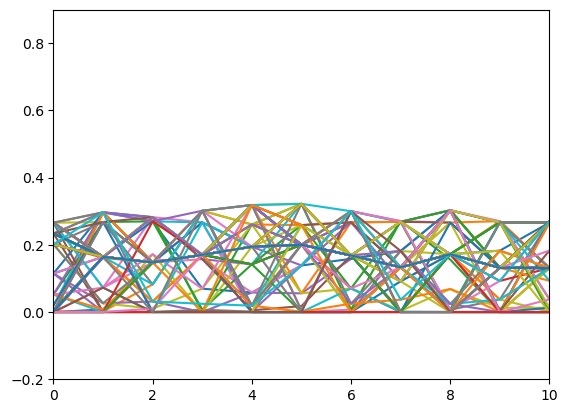

In [15]:
for i in range(91):
    plt.plot(poisson.pmf(S[:, i], rates.mean(1)))
plt.ylim(-0.2, 0.9)
plt.xlim(0, 10)

In [16]:
P = np.array([poisson.pmf(S[:, i], rates.mean(1)) for i in range(91)]).T

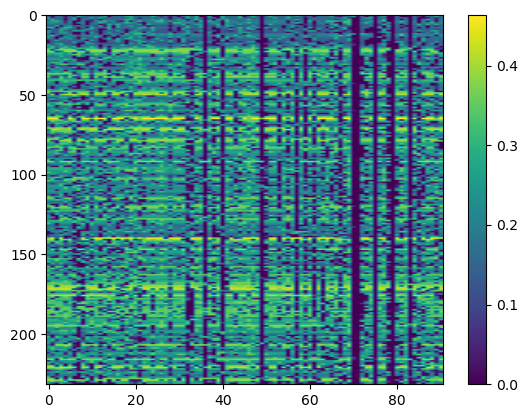

In [17]:
plt.imshow(P, aspect="auto")
plt.colorbar()

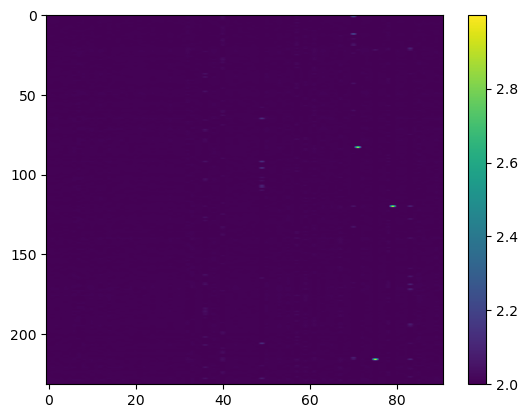

In [20]:
plt.imshow(P / P.sum(0), aspect="auto")
plt.colorbar()

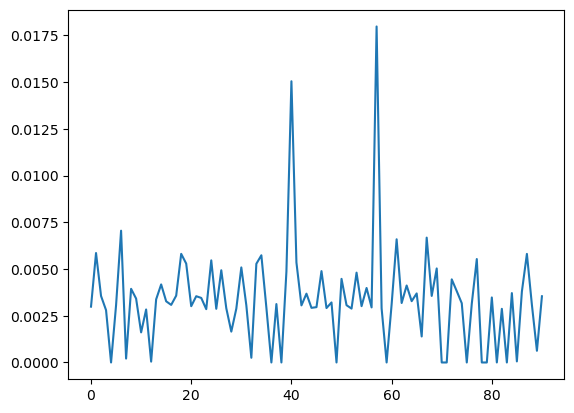

In [96]:
NP = P / P.sum(0)
plt.plot(NP[3, :])

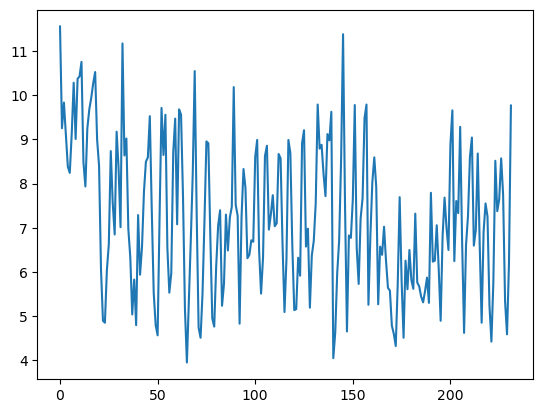

In [61]:
plt.plot(S.mean(1))

In [51]:
from scipy.stats import poisson

In [ ]:
fs = 13
plt.plot(Y[:, 0], Y[:, 1])
plt.xlabel("pos_x", fontsize=fs)
plt.ylabel("pos_y", fontsize=fs)

(232, 91)

# Decoding position given spiking data

The following equation outlines Bayes rule:

$$p(position | spikes) = \frac{p(spikes|position) p(position)}{p(spikes)}$$

$p(position | spike)$ is called the posterior distribution

$p(spikes | position)$ is called the likelihood and it will take on the form of a Poisson distribution

$p(position)$ is the prior and for our purposes we'll assume it is a Uniform distribution (so we can just ignore it in practice but we'll be pedantic and have you implement a prior anyways)

$p(spikes) = \sum_{(x,y) \in pos} p(spikes|(x,y))p((x,y))$

In [14]:
from scipy.stats import poisson

In [14]:
mu_spikes = S.mean(1).round() # simplifying, probably wrong

In [15]:
def likelihood(spikes, rates):
    R = np.zeros((len(spikes), len(rates)))
    
    for j, rate in enumerate(rates):
        R[:, j] = poisson.pmf(spikes, rate)
    
    return R

In [16]:
L = likelihood(mu_spikes, list(range(20)))

In [17]:
import matplotlib.pyplot as plt

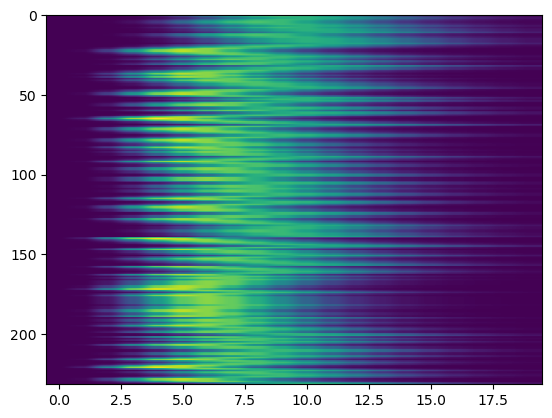

In [18]:
plt.imshow(L, aspect="auto")

In [19]:
def marginal_likelihood(spikes, rate, positions):
    pass

In [20]:
pos_x

array([456.5011091 , 456.50549567, 456.51900724, ..., 459.78818765,
       459.52386797, 459.30292077])

In [21]:
min_pos_x = pos_x.min().round().astype(int)
max_pos_x = pos_x.max().round().astype(int)

min_pos_y = pos_y.min().round().astype(int)
max_pos_y = pos_y.max().round().astype(int)

In [22]:
x_pos_grid = np.arange(min_pos_x, max_pos_x)

In [23]:
y_pos_grid = np.arange(min_pos_y, max_pos_y)

In [24]:
y_pos_grid.shape, x_pos_grid.shape

((377,), (439,))

In [25]:
from itertools import product

In [89]:
xygrid = np.array(list(product(x_pos_grid, y_pos_grid)))

In [90]:
xygrid.shape

(165503, 2)

In [26]:
S.shape

(232, 91)

In [27]:
pos_x.shape

(60000,)

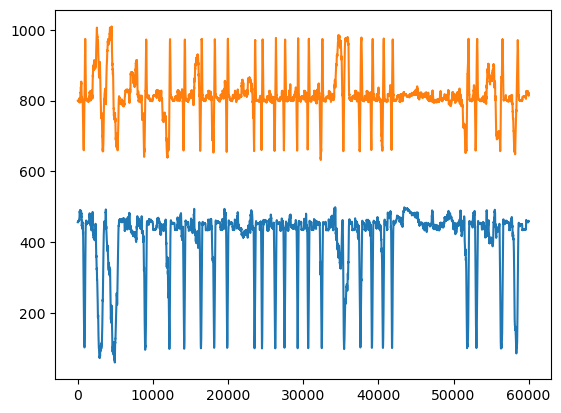

In [28]:
plt.plot(pos_x)
plt.plot(pos_y)

In [29]:
ax,bx = np.histogram(pos_x, 100)

In [30]:
ay,by = np.histogram(pos_y, 100)

In [31]:
new_posx = np.zeros_like(pos_x)
new_posy = np.zeros_like(pos_y)

for j in range(len(bx)-1):
    iix = np.logical_and(pos_x > bx[j], pos_x < bx[j+1])
    new_posx[iix] = pos_x[iix].mean()
    
for j in range(len(by)-1):
    iiy = np.logical_and(pos_y > by[j], pos_y < by[j+1])
    
    new_posy[iiy] = pos_y[iiy].mean()



In [32]:
zx = np.where(new_posx == 0)[0]
zy = np.where(new_posy == 0)[0]

for i in zx:
    new_posx[i] = np.concatenate([new_posx[i-10:i-1], new_posx[i+1:i+10]]).mean()
    
for i in zy:
    new_posy[i] = np.concatenate([new_posy[i-10:i-1], new_posy[i+1:i+10]]).mean()


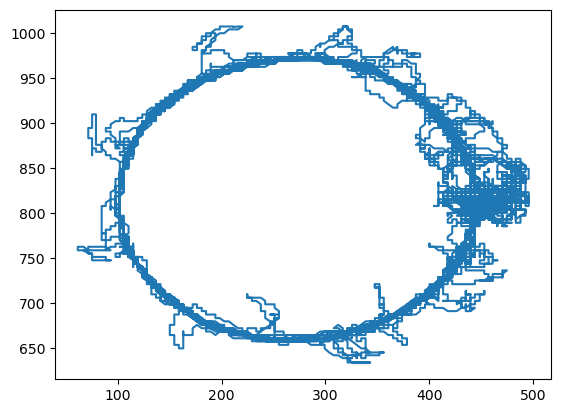

In [33]:
plt.plot(new_posx, new_posy)

In [281]:
pos = np.array([new_posx, new_posy]).T

In [38]:
P = np.array(list(product(np.unique(new_posx), np.unique(new_posy))))

In [45]:
pos_inds

array([  61.49046919,  156.06773956,  250.64500993,  345.2222803 ,
        439.79955067,  534.37682104,  628.95409141,  723.53136177,
        818.10863214,  912.68590251, 1007.26317288])

In [61]:
pos_counts, pos_inds = np.histogram(P, 9)

In [64]:
probs = pos_counts / pos_counts.sum()

array([0.12376238, 0.11881188, 0.11881188, 0.11881188, 0.01980198,
       0.07920792, 0.13861386, 0.13861386, 0.14356436])

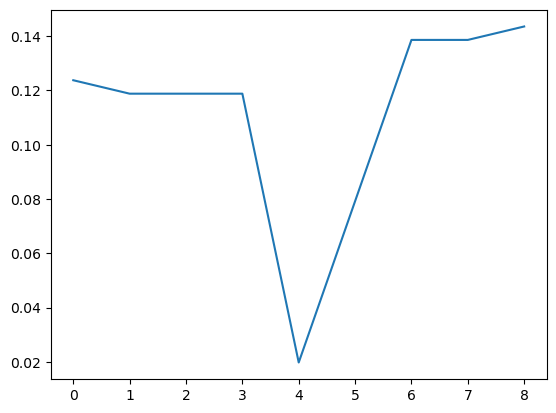

In [63]:
plt.plot(pos_counts / pos_counts.sum())

In [177]:
pos_probs = pos_counts / pos_counts.sum()

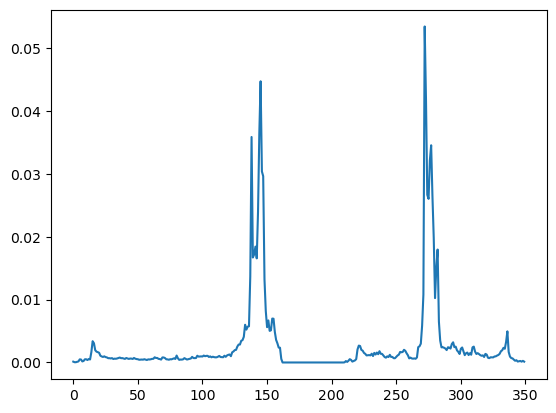

In [178]:
plt.plot(pos_probs)

In [180]:
post_inds

array([  60.07602898,   79.0621703 ,   98.04831163,  117.03445296,
        136.02059428,  155.00673561,  173.99287694,  192.97901826,
        211.96515959,  230.95130092,  249.93744225,  268.92358357,
        287.9097249 ,  306.89586623,  325.88200755,  344.86814888,
        363.85429021,  382.84043153,  401.82657286,  420.81271419,
        439.79885551,  458.78499684,  477.77113817,  496.75727949,
        515.74342082,  534.72956215,  553.71570347,  572.7018448 ,
        591.68798613,  610.67412746,  629.66026878,  648.64641011,
        667.63255144,  686.61869276,  705.60483409,  724.59097542,
        743.57711674,  762.56325807,  781.5493994 ,  800.53554072,
        819.52168205,  838.50782338,  857.4939647 ,  876.48010603,
        895.46624736,  914.45238869,  933.43853001,  952.42467134,
        971.41081267,  990.39695399, 1009.38309532])

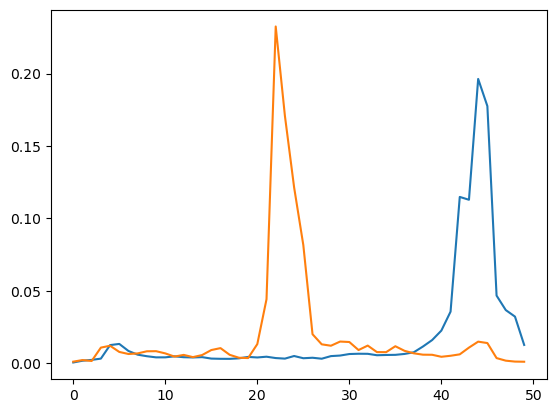

In [159]:
plt.plot(ax / ax.sum())
plt.plot(ay / ay.sum())

In [160]:
p_x = ax / ax.sum()
p_y = ay / ay.sum()

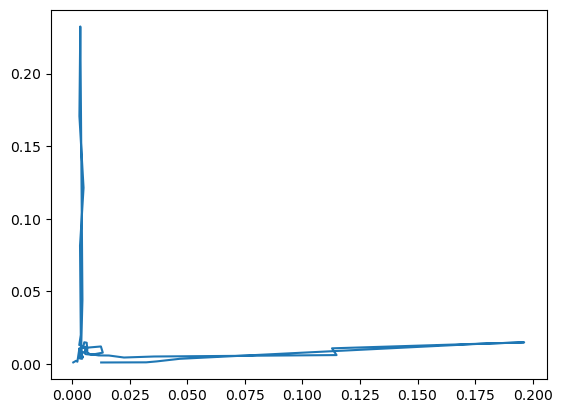

In [161]:
plt.plot(p_x, p_y)

In [140]:
data_dict["data"]["session"]

['150401_1702_circleTrack',
 '150401_1118_circleTrack_20-30minPostScopInj',
 '150401_1025_circleTrack']

In [167]:
pos_inds

array([  60.07602898,   79.0621703 ,   98.04831163,  117.03445296,
        136.02059428,  155.00673561,  173.99287694,  192.97901826,
        211.96515959,  230.95130092,  249.93744225,  268.92358357,
        287.9097249 ,  306.89586623,  325.88200755,  344.86814888,
        363.85429021,  382.84043153,  401.82657286,  420.81271419,
        439.79885551,  458.78499684,  477.77113817,  496.75727949,
        515.74342082,  534.72956215,  553.71570347,  572.7018448 ,
        591.68798613,  610.67412746,  629.66026878,  648.64641011,
        667.63255144,  686.61869276,  705.60483409,  724.59097542,
        743.57711674,  762.56325807,  781.5493994 ,  800.53554072,
        819.52168205,  838.50782338,  857.4939647 ,  876.48010603,
        895.46624736,  914.45238869,  933.43853001,  952.42467134,
        971.41081267,  990.39695399, 1009.38309532])

array([   63,   129,    91,   645,   722,   466,   380,   405,   493,
         497,   405,   273,   343,   251,   336,   544,   624,   346,
         225,   212,   791,  2650, 13951, 10244,  7283,  4892,  1200,
         781,   723,   896,   877,   544,   729,   459,   457,   702,
         512,   409,   352,   348,   265,   307,   366,   645,   892,
         834,   211,   104,    66,    60])

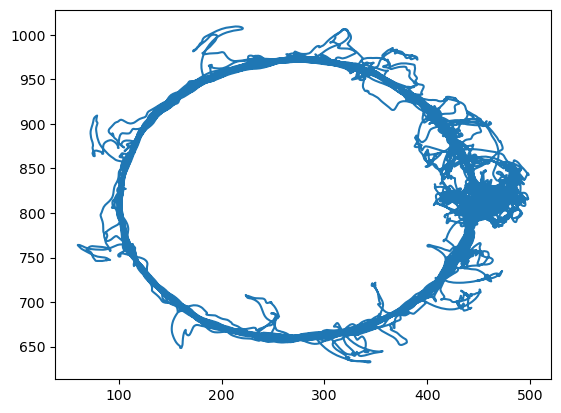

In [175]:
plt.plot(pos[:, 0], pos[:, 1])